<a href="https://colab.research.google.com/github/chcorophyll/my_deeplearning_cookbook/blob/master/my_Building_an_inverse_image_search_service.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chcorophyll/deep_learning_cookbook.git

Cloning into 'deep_learning_cookbook'...
remote: Enumerating objects: 427, done.
remote: Total 427 (delta 0), reused 0 (delta 0), pack-reused 427
Receiving objects: 100% (427/427), 160.26 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (86/86), done.


In [2]:
!ls

deep_learning_cookbook	sample_data


In [0]:
import os

path_org = os.getcwd()
path_data = os.path.join(path_org, "deep_learning_cookbook")
os.chdir(path_data)

In [4]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import imshow
import requests
import random
import os
import base64
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from hashlib import md5
import pickle
try:
    from urllib import unquote
except ImportError:
    from urllib.parse import unquote
from PIL import Image
import requests
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
from IPython.display import HTML, Image as iPythonImage, display
import numpy as np
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
!pip install sparqlwrapper

     |████████████████████████████████| 348kB 21.8MB/s 
     |████████████████████████████████| 51kB 26.2MB/s 


In [7]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT ?item ?itemLabel ?pic
WHERE
{
?item wdt:P31 wd:Q146 .
?item wdt:P18 ?pic
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }
}"""


def get_results(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    print(result["pic"]["value"])
    
images = [x["pic"]["value"] for x in results["results"]["bindings"]]

http://commons.wikimedia.org/wiki/Special:FilePath/%D0%9D%D0%B0%D1%82%D0%B0%D0%BB%D0%B8%D1%8F%20%D0%A3%D1%88%D0%B0%D0%BA%D0%BE%D0%B2%D0%B0.%201927.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Ayasofya%20Gli%20cat.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Fat%20cat%2C%20asleep%20%28319313958%29.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Crimean%20Tom.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Stationmaster%20NITAMA%2020110105.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Foss%20Couchant.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/%C5%9Eero%20CHP.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Naro%2C%20blue-eyed%20cross-siamese%20cat%2C%20at%20Josselin%2004.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Ccandowner2003.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Orangey%20with%20Audrey%20Hepburn%20in%20Breakfast%20at%20Tiffanys.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Mrschippy2.png

In [8]:
len(images), random.sample(images, 10)

(34,
 ['http://commons.wikimedia.org/wiki/Special:FilePath/Grumpy%20Cat%20by%20Gage%20Skidmore.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Tombili%20statue%20Istanbul.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Mr%20Nuts%20Executive%20Portrait.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Mrschippy2.png',
  'http://commons.wikimedia.org/wiki/Special:FilePath/WhiteHousePets%2C%20ValentinesDay2007.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/IndioCat.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Orangey%20with%20Audrey%20Hepburn%20in%20Breakfast%20at%20Tiffanys.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/%C5%9Eero%20CHP.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Fat%20cat%2C%20asleep%20%28319313958%29.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Hamish%20McHamish%20In%20Bookshop.jpg'])

In [0]:
IMAGE_DIR = "wp_images"
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

In [0]:
def center_crop_resize(img, new_size):
    w, h = img.size
    s = min(w, h)
    y = (h-s) // 2
    x = (w-s) // 2
    img = img.crop((x, y, s, s))
    return img.resize((new_size, new_size))


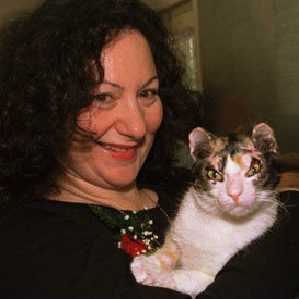

In [18]:
def fetch_image(image_cache, image_url):
    image_name = image_url.rsplit('/', 1)[-1]
    local_name = image_name.rsplit('.', 1)[0] + '.jpg'
    local_path = os.path.join(image_cache, local_name)
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        return center_crop_resize(img, 299)
    image_name = unquote(image_name).replace(' ', '_')
    m = md5()
    m.update(image_name.encode('utf8'))
    c = m.hexdigest()
    for prefix in 'http://upload.wikimedia.org/wikipedia/en', 'http://upload.wikimedia.org/wikipedia/commons':
        url = '/'.join((prefix, c[0], c[0:2], image_name))
        r = requests.get(url)
        if r.status_code != 404:
            try:
                img = Image.open(BytesIO(r.content))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(local_path)
                return center_crop_resize(img, 299)
            except IOError:
                pass
    return None

fetch_image(IMAGE_DIR, images[20])

In [19]:
valid_images = []
valid_image_names = []
for image_name in tqdm(images):
    img = fetch_image(IMAGE_DIR, image_name)
    if img:
        valid_images.append(img)
        valid_image_names.append(image_name)

100%|██████████| 34/34 [00:06<00:00,  9.69it/s]


In [20]:
len(valid_images)

17

In [22]:
base_model = InceptionV3(weights="imagenet", include_top=True)
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [0]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("avg_pool").output)

In [0]:
def get_vector(img):
    if not type(img) == list:
        images = [img]
    else:
        images = img
    target_size = int(max(model.input.shape[1:]))
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    return model.predict(pre_processed)

In [25]:
x = get_vector(valid_images[4])
x.shape

(1, 2048)

In [0]:
# chunks = [get_vector(valid_images[i:i+256]) 
#           for i in range(0, len(valid_images), 256)]
# vectors = np.concatenate(chunks)
# vectors.shape

In [27]:
vectors = get_vector(valid_images)
vectors.shape

(17, 2048)

In [0]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm="ball_tree").fit(vectors)

In [0]:
with open("data/image_similarity.pck", "wb") as fout:
    pickle.dump({"nbrs": nbrs, 
                 "image_names": valid_image_names}, fout)

In [0]:
cat = get_vector(Image.open("data/cat.jpg"))
distances, indices = nbrs.kneighbors(cat)

In [0]:
if True:
    images = [Image.open('data/cat.jpg')]
    target_size = int(max(model.input.shape[1:]))
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    x = model.predict(pre_processed)

In [32]:
pre_processed

array([[[[-0.16862744, -0.3490196 , -0.38823527],
         [-0.16862744, -0.32549018, -0.38039213],
         [-0.24705881, -0.372549  , -0.42745095],
         ...,
         [ 0.27058828,  0.082353  , -0.01176471],
         [ 0.27843142,  0.09019613,  0.01176476],
         [ 0.22352946,  0.03529418, -0.03529412]],

        [[-0.18431371, -0.3490196 , -0.38823527],
         [-0.19215685, -0.34117645, -0.3960784 ],
         [-0.23137254, -0.3490196 , -0.41176468],
         ...,
         [ 0.24705887,  0.05882359, -0.03529412],
         [ 0.24705887,  0.05882359, -0.02745098],
         [ 0.19215691,  0.01176476, -0.06666666]],

        [[-0.20784312, -0.35686272, -0.3960784 ],
         [-0.2235294 , -0.3490196 , -0.41176468],
         [-0.23921567, -0.3333333 , -0.40392154],
         ...,
         [ 0.2313726 ,  0.05098045, -0.05882353],
         [ 0.2313726 ,  0.04313731, -0.05098039],
         [ 0.18431377, -0.00392157, -0.08235294]],

        ...,

        [[-0.45098037, -0.47450978, -0

In [33]:
indices

array([[11,  3,  7,  6, 14,  1, 15,  2, 13, 16]])


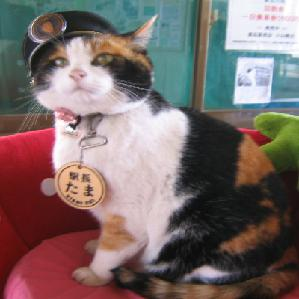
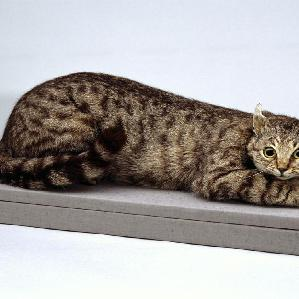
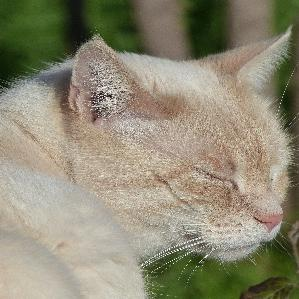
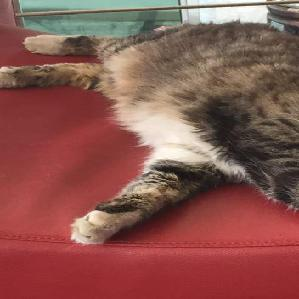
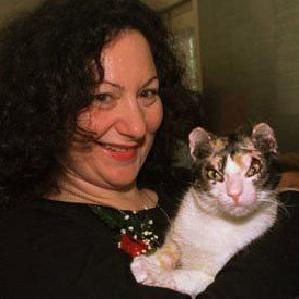
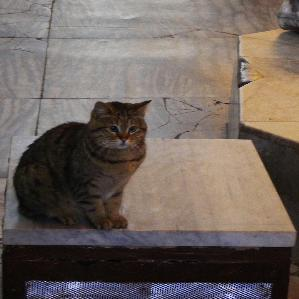
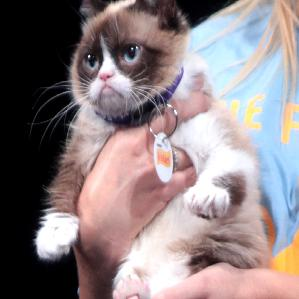
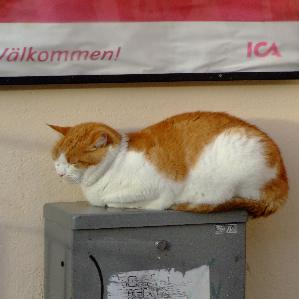
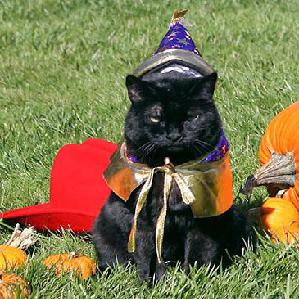
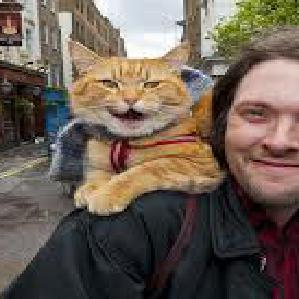

In [36]:
html = []
for idx, dist in zip(indices[0], distances[0]):
    b = BytesIO()
    valid_images[idx].save(b, format="jpeg")
    html.append("<img src='data:image/jpg;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))
HTML("".join(html))


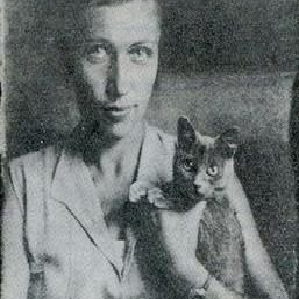

In [37]:
b = BytesIO()
valid_images[0].save(b, format='png')
HTML("<img src='data:image/png;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))

In [0]:
nbrs64 = NearestNeighbors(n_neighbors=64, algorithm='ball_tree').fit(vectors)
distances64, indices64 = nbrs64.kneighbors(cat)

In [0]:
vectors64 = np.asarray([vectors[idx] for idx in indices64[0]])

svd = TruncatedSVD(n_components=2)
vectors64_transformed = svd.fit_transform(vectors64)
vectors64_transformed.shape

In [0]:
img64 = Image.new("RGB", (8*75, 8*75), (180, 180, 180))

mins = np.min(vectors64_transformed, axis=0)
maxs = np.max(vectors64_transformed, axis=0)
xys = (vectors64_transformed - mins) / (maxs - mins)

for idx, (x, y) in zip(indices64[0], xys):
    x = int(x*7)*75
    y = int(y*7)*75
    img64.paste(valid_images[idx].resize((75, 75)), (x, y))